In [ ]:
# !pip install tensorflow
# !pip install matplotlib 

### Dataset

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 256 # size of each image
BATCH_SIZE = 32 # no. of images in each batch
CHANNELS = 3 # rgb channels
EPOCHS = 15

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory="PlantVillage", 
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
    )

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset) # 68 because 2152 images are divided in batch of size 32 each thus total 2152/32 = 68 batches
# last batch may not have 32 images becoz 2152/32 = 67.25

68

In [6]:
for image_batch, label_batch in dataset.take(1): # it gives one batch with 32 images
    print(image_batch.shape) # (images(32), size(256,256), rgb(3))
    print(label_batch.numpy()) #(3 classes(0,1,2) for ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy'])

(32, 256, 256, 3)
[0 1 1 0 0 1 1 1 0 0 1 0 0 0 0 1 0 1 1 0 0 0 1 1 0 0 1 2 1 0 0 1]


#### Data Visualisation

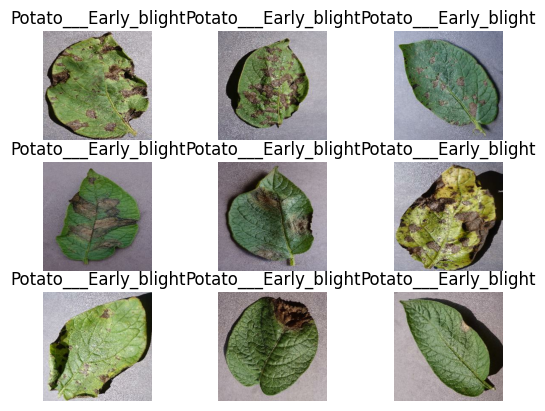

In [9]:
for image_batch, label_batch in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3,3, i+1)
        # print(image_batch[i].shape)
        plt.imshow(image_batch[i].numpy().astype("int"))
        plt.title(class_names[label_batch[0]])
        plt.axis("off")
   

#### Data Splitting

In [10]:
# Train Test Split 
# 80% -> training
# 20% -> 10% validation, 10% testing

# we have 68 batches, 80% of 68 is around 54, thus we use 54 batches data for train
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [11]:
train_ds = dataset.take(54)
len(train_ds)

54

In [12]:
left_ds = dataset.skip(54)
len(left_ds)

14

In [13]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [14]:
val_ds = left_ds.take(6)
len(val_ds)

6

In [15]:
test_ds = left_ds.skip(6)
len(test_ds)

8

In [16]:
# writing a function for above train test split task 
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)

    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [17]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [18]:
len(train_ds), len(val_ds), len(test_ds)

(54, 6, 8)

#### Data Preprocessing

In [19]:
# we will do caching and prefetch
# it will read the image from the disk and then for the next iteration when you need the same image it will keep the image in the memory(RAM)
# also the next batch will be processed without wasting time
# watch this for more - https://www.youtube.com/watch?v=MLEKEplgCas&list=PLeo1K3hjS3uu7CxAacxVndI4bE_o3BDtO&index=45

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# now these datasets are optimizrd for training, and will train fast 

In [20]:
# Scaling the dataset

resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

# all our images are 256x256 but still we are doing resizing becoz this resize_and_rescale image will eventually go to aur model.
# and when we start predicting from model and give any image that is not 256x256 this layer will take care of it and resize it first.


In [21]:
# Data Agumentation
# we add flipped, rotated, Zoomed, Contrasted etc images in dataset to make model more robust for pridiction

data_agumentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

### Creating CNN Model

In [22]:
input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_agumentation,
    layers.Conv2D(32, (3,3), activation="relu", input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation="relu", input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation="relu", input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation="relu", input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation="relu", input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation="relu", input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(n_classes, activation="softmax")
])

model.build(input_shape=input_shape)

c:\Users\utkarsh.alpuria\Desktop\My Work\Python\Python ML\Potato_Disease_1-main\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [23]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [25]:
model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.5255 - loss: 0.9364 - val_accuracy: 0.5417 - val_loss: 0.8911
Epoch 2/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.6825 - loss: 0.7174 - val_accuracy: 0.8073 - val_loss: 0.4295
Epoch 3/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.8414 - loss: 0.4081 - val_accuracy: 0.9219 - val_loss: 0.2211
Epoch 4/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.8579 - loss: 0.3476 - val_accuracy: 0.8958 - val_loss: 0.2377
Epoch 5/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.9090 - loss: 0.2514 - val_accuracy: 0.8854 - val_loss: 0.2699
Epoch 6/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.8879 - loss: 0.2790 - val_accuracy: 0.9427 - val_loss: 0.1574
Epoch 7/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.9210 - loss: 0.1871 - val_accuracy: 0.9427 - val_loss: 0.1221
Epoch 8/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.9211 - loss: 0.1881 - val_accuracy: 0.9375 - val_loss:

In [26]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 267ms/step - accuracy: 0.7762 - loss: 0.5979


In [27]:
scores

[0.5672029256820679, 0.79296875]

first image to predict
actual label:  Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step
prediction:  Potato___Early_blight


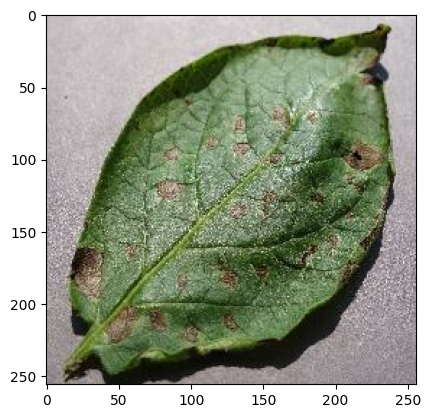

In [28]:
import numpy as np

for images_batch, label_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype("int")
    first_label = label_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label: ", class_names[first_label])

    batch_prediction = model.predict(image_batch)
    print("prediction: ", class_names[np.argmax(batch_prediction[0])])

In [29]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


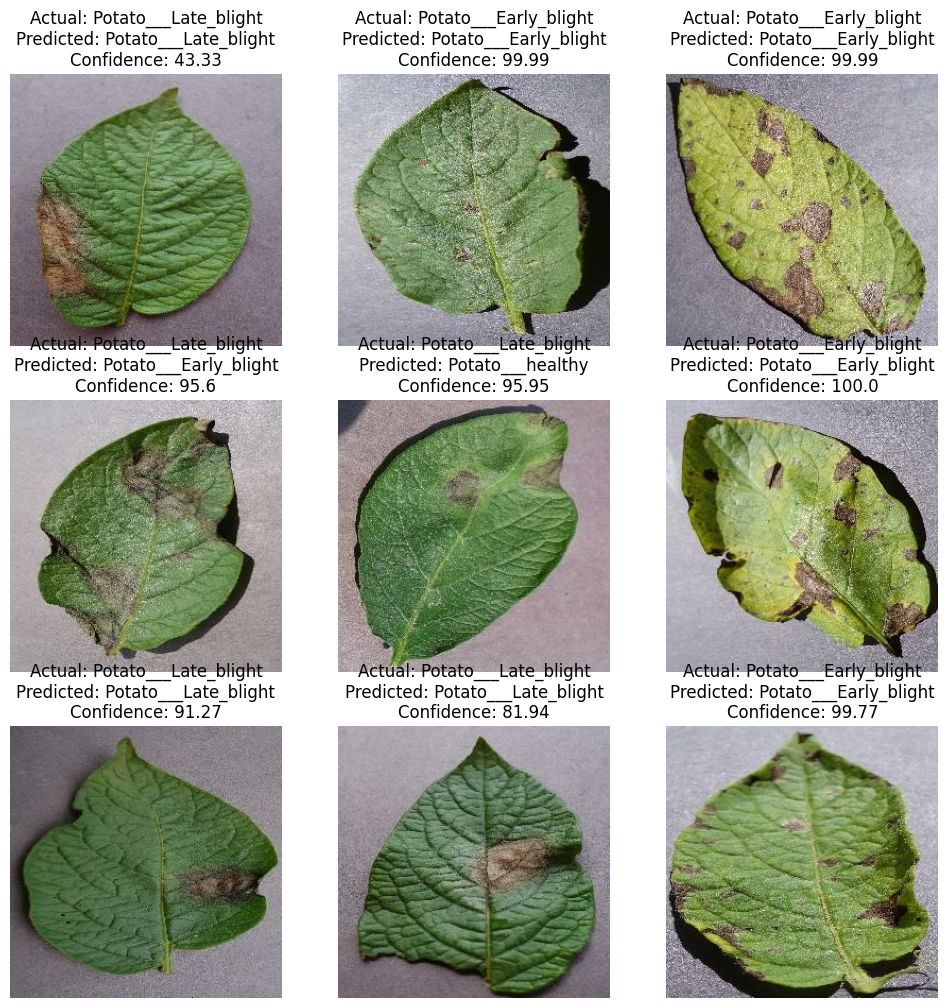

In [30]:
plt.figure(figsize=(12,12))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("int"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence}")
        plt.axis("off")

In [31]:
model_version=2

model.save(f"../Models/{model_version}.keras")

# to load saved model use: 
# model = keras.models.load_model("path")